In [3]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
import random
import numpy as np
from d2l import torch as d2l
from datetime import datetime


/home/whr-pc-ubuntu/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/whr-pc-ubuntu/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


# 网络结构


用类定义网络结构时

-   类必须继承自 nn.Module

-   对网络层逐个进行定义

-   (可选)参数初始化

-   forward 函数


In [4]:
activation_func = nn.Sigmoid()


In [5]:
# 写起来比较简单，但是需要定义初始化函数，初始化函数在网络层比较多时，可能会崩溃
# net = nn.Sequential(
#     nn.Conv2d(1,6,kernel_size=(5,5),padding=(2,2)),nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=(2,2),stride=(2,2)),
#     nn.Conv2d(6,16,kernel_size=(5,5)),nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=(2,2),stride=(2,2)),
#     nn.Flatten(),
#     nn.Linear(16*5*5,120),nn.Sigmoid(),
#     nn.Linear(120,84),nn.Sigmoid(),
#     nn.Linear(84,10)
#     )


In [6]:
class CNN(nn.Module):
    """
        这种写法的优点在于可以将参数初始化、网络层使用顺序函数都定义在类里面
        缺点是比较繁琐
        可以逐个写网络层
        也可以逻辑上再进行划分(如conv2d_block_1), 用nn.Sequential(也继承自nn.Module)进行连接
    """
    def __init__(self) -> None:
        super().__init__()
        self.conv2d_block_1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(5, 5), padding=(2, 2)),
            nn.Sigmoid(),
        )
        # In PyTorch, the nn.MaxPool2d module, for example, does not have any learnable parameters. It simply performs a fixed operation on the input tensor during the forward pass, based on the specified kernel size, stride, padding, and other arguments.
        # 因为两个avgpool的参数相同，所以也可以共用
        self.avgpool2d_1 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2d_block_2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=(5, 5)),
            nn.Sigmoid(),
        )
        self.avgpool2d_2 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.flat = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(16*5*5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def init_params(self,seed):
        """
            self.modules()函数按顺序返回与该module绑定的所有网络层
            可以用来对各个层进行参数初始化

            激活函数选择sigmoid、tanh时,选择Xavier正态分布(normal)或Xavier均匀分布(uniform)
            选择relu时, 选择kaiming正态分布或均匀分布

            以_结尾的函数表示对传入的tensor进行替换, 不以_结尾的函数只是返回一个用来进行参数初始化的tensor
        """
        torch.manual_seed(seed)
        for module in self.modules(): # This will print the instances of all modules, including nested ones.
            # print(module)
            if isinstance(module,nn.Conv2d) or isinstance(module,nn.Linear):
                nn.init.xavier_normal_(module.weight.data)
                nn.init.zeros_(module.bias.data)

    def forward(self,x):
        x = self.conv2d_block_1(x)
        x = self.avgpool2d_1(x)
        x = self.conv2d_block_2(x)
        x = self.avgpool2d_2(x)
        x = self.flat(x)
        x = self.fc(x)
        return x
        

In [7]:
net = CNN()


In [8]:
# nested，只是在init函数中定义的顺序，也就是属性中属于nn.module类的属性的定义顺序
# 不一定是forward函数中的使用顺序
for module in net.modules():
    print(module)


CNN(
  (conv2d_block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
  )
  (avgpool2d_1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv2d_block_2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
  )
  (avgpool2d_2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
)
Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Sigmoid()
AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
Sequential(
  (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): Sigmoid()
)

In [9]:
# 检验参数初始化的结果
for m in net.modules():
    print(1)
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        print(m.bias, m.weight)


1
1
1
Parameter containing:
tensor([-0.0892, -0.1445, -0.1351, -0.1657,  0.1236,  0.0798],
       requires_grad=True) Parameter containing:
tensor([[[[ 0.1781,  0.0468,  0.0848,  0.0388, -0.0697],
          [-0.1153, -0.0390, -0.0380,  0.0805,  0.1866],
          [-0.1781, -0.0207, -0.0194,  0.1989,  0.0332],
          [ 0.0813,  0.1362, -0.0096, -0.1264,  0.1595],
          [-0.0666, -0.1235,  0.0817,  0.0088,  0.1987]]],


        [[[-0.1149,  0.0570, -0.1944,  0.1940,  0.1119],
          [-0.1734, -0.1993, -0.0176, -0.1236,  0.1775],
          [-0.1646,  0.1267, -0.0859,  0.1892,  0.1452],
          [ 0.1443, -0.1635, -0.0598,  0.1419, -0.0718],
          [-0.0178, -0.1952, -0.0416, -0.1045,  0.0007]]],


        [[[ 0.0683, -0.1194,  0.0762, -0.0860, -0.0198],
          [ 0.0227,  0.1339,  0.1955,  0.0106, -0.0118],
          [ 0.0874,  0.1531,  0.1826,  0.0987, -0.0687],
          [-0.0862,  0.0257,  0.1574, -0.0145, -0.1089],
          [-0.0950,  0.1409, -0.1698,  0.0663,  0.0696

In [10]:
# modules()是嵌套访问
# children是直接访问最外层的module
# 和modules()一样，都只是在init函数中定义的顺序，也就是属性中属于nn.module类的属性的定义顺序

# 中间计算结果的维度
x = torch.rand((1, 1, 28, 28))
for layer in net.children():
    x = layer(x)
    print(layer.__class__.__name__, x.shape)


Sequential torch.Size([1, 6, 28, 28])
AvgPool2d torch.Size([1, 6, 14, 14])
Sequential torch.Size([1, 16, 10, 10])
AvgPool2d torch.Size([1, 16, 5, 5])
Flatten torch.Size([1, 400])
Sequential torch.Size([1, 10])


# 加载数据


In [ ]:
dataset_path = '/home/whr-pc-ubuntu/code/fl/data'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), ]
)

train_dataset = torchvision.datasets.FashionMNIST(
    root=dataset_path,
    transform=transform,
    train=True,
    download=True
)
test_dataset = torchvision.datasets.FashionMNIST(
    root=dataset_path,
    transform=transform,
    train=False,
    download=True
)

seed = 59
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size, True)
test_dataloader = DataLoader(test_dataset, batch_size, True)


In [17]:
next(iter(train_dataloader))


[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [18]:
# 256 batch_size
# 1 input_channel
# 28*28 pixel
next(iter(train_dataloader))[0].shape


torch.Size([128, 1, 28, 28])

In [19]:
# label
next(iter(train_dataloader))[1].shape


torch.Size([128])

# cpu 训练


In [20]:
def cpu_train(net, train_dataloader,test_dataloader,seed, epoch, lr, momentum=None):
    net.init_params(seed) # 问题2: 参数初始化, 必要的，否则经过很多轮迭代三个指标都不会发生变化
        
    if momentum and isinstance(momentum, float):
        optimizer = torch.optim.SGD(net.parameters(), lr, momentum=momentum)
    else:
        optimizer = torch.optim.SGD(net.parameters(), lr)

    loss_func = nn.CrossEntropyLoss()
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', legend=['train loss', 'train acc', 'test acc'])

    timer.start()
    for e in range(epoch):
        torch.manual_seed(seed)
        metric = d2l.Accumulator(3)  # loss，正确数，数据量
        for x, y in train_dataloader:
            before = [params.clone().detach() for params in list(net.parameters())]
            
            optimizer.zero_grad()  # 问题1: 梯度清零，否则错误
            y_hat = net(x)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer.step()
            
            after = [params.clone().detach() for params in list(net.parameters())]
            sum = 0
            for i,j in zip(before,after):
                sum += (j-i).sum()
            # print(f"更新幅度为{sum}")

            with torch.no_grad():
                metric.add(loss*x.shape[0], d2l.accuracy(y_hat, y), x.shape[0])

        train_loss = metric[0]/metric[2]
        train_acc = metric[1]/metric[2]
        test_acc = d2l.evaluate_accuracy(net, test_dataloader)
        print(train_acc, test_acc)

        animator.add(e+1,(train_loss,train_acc,test_acc))

    animator.fig.savefig(f'{datetime.strftime(datetime.now(),"%Y-%m-%d-%H-%M-%S")}.jpg')
    timer.stop()

    return timer


In [21]:
epoch = 30
lr = 0.1

## 无momentum

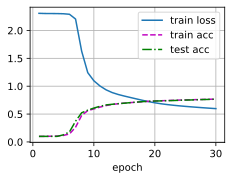

In [28]:
net = CNN()
timer = cpu_train(net, train_dataloader, test_dataloader, seed,epoch, lr)


## 有momentum

可以看到, 极大的缩短了收敛所需要的迭代次数

In [19]:
momentum = 0.9

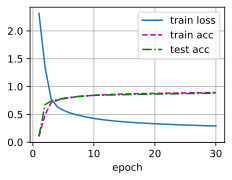

In [22]:
# 加入momentum
net = CNN()
timer = cpu_train(net, train_dataloader, test_dataloader, seed,epoch, lr, momentum)


# gpu 训练


In [22]:
d2l.try_gpu()

device(type='cuda', index=0)

KeyboardInterrupt: 

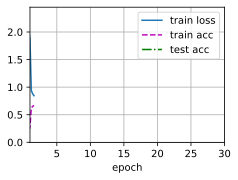

In [23]:
net = CNN()
net.init_params(seed)
d2l.train_ch6(net, train_dataloader, test_dataloader, 30, 0.9, d2l.try_gpu())


In [25]:
device =  torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu:0")
device

device(type='cuda', index=0)

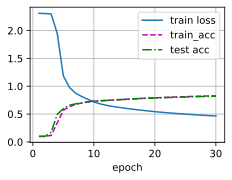

In [27]:
net = CNN()
net.init_params(seed)
net.to(device) # 网络，准确来说是参数也需要放到GPU里面
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(net.parameters(),lr)
animator = d2l.Animator(xlabel='epoch',legend=['train loss','train_acc','test acc'])

for i in range(epoch):
    torch.manual_seed(seed)
    accumulator = d2l.Accumulator(3) # train_loss, train_acc, count
    for x,y in train_dataloader:
        optim.zero_grad()
        x = x.to(device)
        y = y.to(device) # torch.int64
        y_hat = net(x)
        train_loss = loss_func(y_hat,y) # 顺序不能颠倒，否则报错"host_softmax" not implemented for "long", 因为y是int64类型
        train_loss.backward()
        optim.step()

        # train acc
        # y_hat就在GPU上，无需转移
        # 比较y_hat行中，最大数的index是否与y对应值相同
        with torch.no_grad():
            # display(y.shape) # torch.Size([128])
            # display(y_hat.shape) # torch.Size([128, 10])
            # display(y_hat)
            # display(y_hat.argmax(dim=1).shape)
            # display((y_hat.argmax(dim=1) == y).sum().float().item())
            train_acc = (y_hat.argmax(dim=1) == y).sum().float().item()

        accumulator.add(train_loss*x.shape[0],train_acc,x.shape[0]) # 交叉熵损失函数取了平均

    # test acc
    # accumulator_2 = d2l.Accumulator(2)
    # for x,y in test_dataloader:
    #     x = x.to(device)
    #     y = y.to(device)
    #     y_hat = net(x)
    #     with torch.no_grad():
    #         test_acc = (y_hat.argmax(dim=1) == y).sum().float().item()

    #     accumulator_2.add(test_acc,x.shape[0])

    
    # animator.add(i+1,(accumulator[0]/accumulator[2],accumulator[1]/accumulator[2],accumulator_2[0]/accumulator_2[1]))

    torch.randn
    test_acc = d2l.evaluate_accuracy_gpu(net,test_dataloader)
    animator.add(i+1,(accumulator[0]/accumulator[2],accumulator[1]/accumulator[2],test_acc))
    